In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report, ndcg_score

import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
df_train = pd.read_csv("/kaggle/input/vk-contest-mle/train_df.csv")
df_test = pd.read_csv("/kaggle/input/vk-contest-mle/test_df.csv")

X_train = df_train[df_train.columns[1:-1]].to_numpy()
X_test = df_test[df_test.columns[1:-1]].to_numpy()

y_train = df_train["target"].to_numpy()
y_test = df_test["target"].to_numpy() 

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15081, 79) (15081,) (1529, 79) (1529,)


# Raw data 

In [9]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

print(X_train_tensor)
print(y_train_tensor)

tensor([[9.0000, 0.0000, 0.0000,  ..., 0.3865, 0.0000, 0.0000],
        [9.0000, 0.0000, 0.0000,  ..., 0.1098, 0.0000, 0.0000],
        [9.0000, 0.0000, 0.0000,  ..., 0.0367, 0.0000, 0.0000],
        ...,
        [9.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [9.0000, 0.0000, 0.0000,  ..., 0.6761, 0.0000, 0.0000],
        [9.0000, 0.0000, 0.0000,  ..., 0.5367, 0.0000, 0.0000]])
tensor([0., 0., 0.,  ..., 0., 0., 1.])


In [10]:
BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

In [11]:
n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.output  = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
#         x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

model = SimpleFFN()
print(model)

SimpleFFN(
  (layer_1): Linear(in_features=79, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Loss gets:
	 - y_pred.shape: torch.Size([128, 1]), y_pred.squeeze().shape: torch.Size([128]), y_batch.shape: torch.Size([128])
Epoch 1/50
	 - loss: 0.154868945479393
Epoch 2/50
	 - loss: 0.15179380774497986
Epoch 3/50
	 - loss: 0.1496787816286087
Epoch 4/50
	 - loss: 0.14808300137519836
Epoch 5/50
	 - loss: 0.14710314571857452
Epoch 6/50
	 - loss: 0.14654530584812164
Epoch 7/50
	 - loss: 0.1464507281780243
Epoch 8/50
	 - loss: 0.14671605825424194
Epoch 9/50
	 - loss: 0.14707379043102264
Epoch 10/50
	 - loss: 0.14750562608242035
Epoch 11/50
	 - loss: 0.1477998048067093
Epoch 12/50
	 - loss: 0.14820784330368042
Epoch 13/50
	 - loss: 0.14843837916851044
Epoch 14/50
	 - loss: 0.14892888069152832
Epoch 15/50
	 - loss: 0.14929181337356567
Epoch 16/50
	 - loss: 0.14917363226413727
Epoch 17/50
	 - loss: 0.14928051829338074
Epoch 18/50
	 - loss: 0.14954349398612976
Epoch 19/50
	 - loss: 0.14992205798625946
Epoch 20/50
	 - loss: 0.1502666175365448
Epoch 21/50
	 - loss: 0.15042535960674286
Epoch 

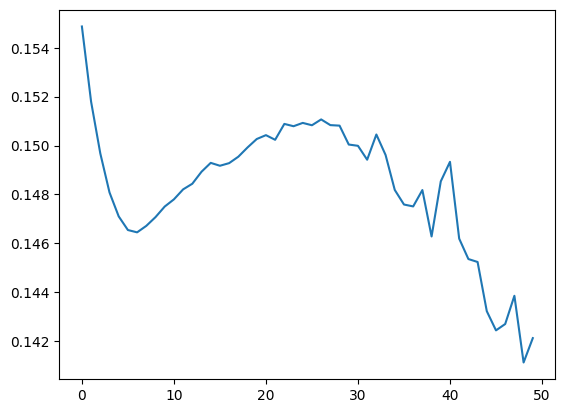

0.42437627410885675


In [12]:
loss_func = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    for i, (X_batch, y_batch) in enumerate(train_dl):
        y_pred = model(X_batch)
        if epoch == 0 and i == 0:
            print(f"Loss gets:\n\t - y_pred.shape: {y_pred.shape}, y_pred.squeeze().shape: {y_pred.squeeze().shape}, y_batch.shape: {y_batch.shape}")
        loss = loss_func(y_pred.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    history.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}")
    
plt.plot(history)
plt.show()

model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()
    
print(ndcg_score([y_test], [y_pred[:, 0]]))

## WO Batch

In [20]:
model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 200

model.train()
history = []
for epoch in range(epochs):
    y_pred = model(X_train_tensor)
    loss = loss_func(y_pred.squeeze(), y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}")

model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/200
	 - loss: 0.7288742065429688
Epoch 2/200
	 - loss: 0.6437998414039612
Epoch 3/200
	 - loss: 0.5667120218276978
Epoch 4/200
	 - loss: 0.4979899525642395
Epoch 5/200
	 - loss: 0.4377005696296692
Epoch 6/200
	 - loss: 0.3860498070716858
Epoch 7/200
	 - loss: 0.34324219822883606
Epoch 8/200
	 - loss: 0.30708006024360657
Epoch 9/200
	 - loss: 0.27573713660240173
Epoch 10/200
	 - loss: 0.2485532909631729
Epoch 11/200
	 - loss: 0.2251981943845749
Epoch 12/200
	 - loss: 0.20521770417690277
Epoch 13/200
	 - loss: 0.18812616169452667
Epoch 14/200
	 - loss: 0.1735527664422989
Epoch 15/200
	 - loss: 0.1612139195203781
Epoch 16/200
	 - loss: 0.15081775188446045
Epoch 17/200
	 - loss: 0.14207695424556732
Epoch 18/200
	 - loss: 0.1347680240869522
Epoch 19/200
	 - loss: 0.128712996840477
Epoch 20/200
	 - loss: 0.12376629561185837
Epoch 21/200
	 - loss: 0.11981583386659622
Epoch 22/200
	 - loss: 0.11676495522260666
Epoch 23/200
	 - loss: 0.11450411379337311
Epoch 24/200
	 - loss: 0.11294367

## Scaled data

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit(X_test)

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

In [22]:
model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 200

model.train()
history = []
for epoch in range(epochs):
    y_pred = model(X_train_tensor)
    loss = loss_func(y_pred.squeeze(), y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history.append(loss.item())
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred = model(X_test_tensor).detach().numpy()
        score = ndcg_score([y_test], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")

model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/200
	 - loss: 0.44077736139297485, score: 0.4706667914341851
Epoch 11/200
	 - loss: 0.11833155900239944, score: 0.5042908326628358
Epoch 21/200
	 - loss: 0.11482520401477814, score: 0.5084224513823689
Epoch 31/200
	 - loss: 0.11338690668344498, score: 0.5107281173748379
Epoch 41/200
	 - loss: 0.10791806131601334, score: 0.5191417036247712
Epoch 51/200
	 - loss: 0.10595747083425522, score: 0.5248242580044179
Epoch 61/200
	 - loss: 0.10468851029872894, score: 0.46916660817456685
Epoch 71/200
	 - loss: 0.10374122858047485, score: 0.42442893356475875
Epoch 81/200
	 - loss: 0.10300610959529877, score: 0.43930232867129076
Epoch 91/200
	 - loss: 0.102327361702919, score: 0.45912353726021815
Epoch 101/200
	 - loss: 0.10168977826833725, score: 0.46037456237751306
Epoch 111/200
	 - loss: 0.10110168904066086, score: 0.4663038198367495
Epoch 121/200
	 - loss: 0.10055717825889587, score: 0.46264481353425363
Epoch 131/200
	 - loss: 0.10005210340023041, score: 0.4587910801137741
Epoch 141/200

In [23]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit(X_test)

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    y_pred = model(X_train_tensor)
    loss = loss_func(y_pred.squeeze(), y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history.append(loss.item())
    if epoch % 1 == 0:
        with torch.no_grad():
            y_pred = model(X_test_tensor).detach().numpy()
        score = ndcg_score([y_test], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")

model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/50
	 - loss: 0.9098692536354065, score: 0.4648920526901544
Epoch 2/50
	 - loss: 0.24574650824069977, score: 0.49876858538224716
Epoch 3/50
	 - loss: 0.1213768795132637, score: 0.49655783787155583
Epoch 4/50
	 - loss: 0.12238206714391708, score: 0.4967670711371546
Epoch 5/50
	 - loss: 0.14702871441841125, score: 0.49702432414419373
Epoch 6/50
	 - loss: 0.16353048384189606, score: 0.49733412724158865
Epoch 7/50
	 - loss: 0.1688489466905594, score: 0.4980160328936005
Epoch 8/50
	 - loss: 0.16591885685920715, score: 0.49889116095110086
Epoch 9/50
	 - loss: 0.15852844715118408, score: 0.4988889780235865
Epoch 10/50
	 - loss: 0.14743387699127197, score: 0.49885579489126475
Epoch 11/50
	 - loss: 0.13482269644737244, score: 0.4989939081898641
Epoch 12/50
	 - loss: 0.12295963615179062, score: 0.49912433645427107
Epoch 13/50
	 - loss: 0.11398971080780029, score: 0.5003556359560586
Epoch 14/50
	 - loss: 0.10961771756410599, score: 0.5042955549362682
Epoch 15/50
	 - loss: 0.109936453402042

In [24]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit(X_test)

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    for i, (X_batch, y_batch) in enumerate(train_dl):
        y_pred = model(X_batch)
        if epoch == 0 and i == 0:
            print(f"Loss gets:\n\t - y_pred.shape: {y_pred.shape}, y_pred.squeeze().shape: {y_pred.squeeze().shape}, y_batch.shape: {y_batch.shape}")
        loss = loss_func(y_pred.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 1 == 0:
        with torch.no_grad():
            y_pred = model(X_test_tensor).detach().numpy()
        score = ndcg_score([y_test], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Loss gets:
	 - y_pred.shape: torch.Size([128, 1]), y_pred.squeeze().shape: torch.Size([128]), y_batch.shape: torch.Size([128])
Epoch 1/50
	 - loss: 0.161721870303154, score: 0.5227941229637659
Epoch 2/50
	 - loss: 0.15615667402744293, score: 0.42559114547294064
Epoch 3/50
	 - loss: 0.15395307540893555, score: 0.44734076808906215
Epoch 4/50
	 - loss: 0.1511128693819046, score: 0.4564897137592122
Epoch 5/50
	 - loss: 0.14945773780345917, score: 0.45656890435900915
Epoch 6/50
	 - loss: 0.14834634959697723, score: 0.4489149080646051
Epoch 7/50
	 - loss: 0.14840452373027802, score: 0.44550662895263926
Epoch 8/50
	 - loss: 0.14828906953334808, score: 0.45067898835932835
Epoch 9/50
	 - loss: 0.14851662516593933, score: 0.44799904118347716
Epoch 10/50
	 - loss: 0.1487973928451538, score: 0.44904819204314206
Epoch 11/50
	 - loss: 0.1490952968597412, score: 0.4452367678448462
Epoch 12/50
	 - loss: 0.14938370883464813, score: 0.44524123078733957
Epoch 13/50
	 - loss: 0.14955145120620728, score: 0

In [25]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        
    if epoch % 1 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
            print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/50
	 - loss: 0.18092834949493408, score: 0.39936062000719086
Epoch 2/50
	 - loss: 0.15985190868377686, score: 0.3999429102056161
Epoch 3/50
	 - loss: 0.1488252729177475, score: 0.41040141038574035
Epoch 4/50
	 - loss: 0.14679841697216034, score: 0.4250035515314582
Epoch 5/50
	 - loss: 0.14698010683059692, score: 0.44053404980836486
Epoch 6/50
	 - loss: 0.14750419557094574, score: 0.451207195925146
Epoch 7/50
	 - loss: 0.1485777050256729, score: 0.45912798663090515
Epoch 8/50
	 - loss: 0.14923955500125885, score: 0.4628952882138938
Epoch 9/50
	 - loss: 0.14970259368419647, score: 0.4675656157665328
Epoch 10/50
	 - loss: 0.15004964172840118, score: 0.4708985646903108
Epoch 11/50
	 - loss: 0.1507570892572403, score: 0.4747216061372041
Epoch 12/50
	 - loss: 0.15107658505439758, score: 0.47911828799525535
Epoch 13/50
	 - loss: 0.15130501985549927, score: 0.4783283130970969
Epoch 14/50
	 - loss: 0.15149815380573273, score: 0.47727471427650403
Epoch 15/50
	 - loss: 0.15186157822608948

In [26]:
n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.output  = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

model = SimpleFFN()
print(model)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    model.train()
#     for X_batch, y_batch in train_dl:
#         optimizer.zero_grad()
#         y_pred = model(X_batch)
#         loss = loss_func(y_pred.squeeze(), y_batch)
#         loss.backward()
#         optimizer.step()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = loss_func(y_pred.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
        
    if epoch % 1 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
            score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
            print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

SimpleFFN(
  (layer_1): Linear(in_features=79, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 1/50
	 - loss: 0.7072075009346008, score: 0.39345892858654746
Epoch 2/50
	 - loss: 0.6730905175209045, score: 0.38728060705066836
Epoch 3/50
	 - loss: 0.6394951343536377, score: 0.45905686441162524
Epoch 4/50
	 - loss: 0.6059736609458923, score: 0.4560780991350811
Epoch 5/50
	 - loss: 0.5723173022270203, score: 0.45488692729318697
Epoch 6/50
	 - loss: 0.5382355451583862, score: 0.4543714697781022
Epoch 7/50
	 - loss: 0.5030360817909241, score: 0.45356394425305974
Epoch 8/50
	 - loss: 0.466049283742904

In [27]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

X_tra_res, X_val_res, y_tra_res, y_val_res = train_test_split(X_train_resampled, y_train_resampled,
                                                              test_size=0.2, random_state=42, shuffle=True)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_tra_res)
X_val_scaled   = scaler.transform(X_val_res)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_tra_res, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_res, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.output  = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x


BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    
    model.train()
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
#     optimizer.zero_grad()
#     y_pred = model(X_train_tensor)
#     loss = loss_func(y_pred.squeeze(), y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_tensor)
        score = ndcg_score([y_val_tensor.numpy()], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
#     if epoch % 1 == 0:
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test_tensor)
#             score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
#             print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/50
	 - loss: 0.4312545657157898, score: 0.9779275906936035
Epoch 2/50
	 - loss: 0.36127403378486633, score: 0.992487649281052
Epoch 3/50
	 - loss: 0.30876338481903076, score: 0.9968482144068314
Epoch 4/50
	 - loss: 0.1588553786277771, score: 0.9981689330045949
Epoch 5/50
	 - loss: 0.16854935884475708, score: 0.9985619627996146
Epoch 6/50
	 - loss: 0.11450638622045517, score: 0.9990906901528849
Epoch 7/50
	 - loss: 0.07610398530960083, score: 0.9992855330642901
Epoch 8/50
	 - loss: 0.11559917032718658, score: 0.9992960093908961
Epoch 9/50
	 - loss: 0.05412015691399574, score: 0.9995436587208195
Epoch 10/50
	 - loss: 0.07052873075008392, score: 0.9996339222235626
Epoch 11/50
	 - loss: 0.027752486988902092, score: 0.9995818303207218
Epoch 12/50
	 - loss: 0.029716629534959793, score: 0.9996274770031056
Epoch 13/50
	 - loss: 0.015811862424016, score: 0.9996503769756567
Epoch 14/50
	 - loss: 0.051268283277750015, score: 0.9997030837393304
Epoch 15/50
	 - loss: 0.03542456775903702, sc

In [28]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# X_tra_res, X_val_res, y_tra_res, y_val_res = train_test_split(X_train_resampled, y_train_resampled,
#                                                               test_size=0.2, random_state=42, shuffle=True)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.output  = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
#         x = self.dropout(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
#         x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x


BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    
    model.train()
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
#     optimizer.zero_grad()
#     y_pred = model(X_train_tensor)
#     loss = loss_func(y_pred.squeeze(), y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
#     if epoch % 1 == 0:
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test_tensor)
#             score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
#             print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/50
	 - loss: 0.03899206966161728, score: 0.4185169162073368
Epoch 2/50
	 - loss: 0.09386323392391205, score: 0.4252638193824733
Epoch 3/50
	 - loss: 0.16410978138446808, score: 0.4165300659980861
Epoch 4/50
	 - loss: 0.14547713100910187, score: 0.4304082028572023
Epoch 5/50
	 - loss: 0.009551598690450191, score: 0.4371763680744638
Epoch 6/50
	 - loss: 0.27438920736312866, score: 0.41710105065973274
Epoch 7/50
	 - loss: 0.46060416102409363, score: 0.4236493778930321
Epoch 8/50
	 - loss: 0.3779621720314026, score: 0.4603408305941663
Epoch 9/50
	 - loss: 0.5584697127342224, score: 0.4564964070027812
Epoch 10/50
	 - loss: 0.5022994875907898, score: 0.43953419911081104
Epoch 11/50
	 - loss: 0.022025080397725105, score: 0.4473153077801609
Epoch 12/50
	 - loss: 0.0863625779747963, score: 0.47458889001507887
Epoch 13/50
	 - loss: 0.403385728597641, score: 0.543471925613946
Epoch 14/50
	 - loss: 0.5217925906181335, score: 0.5824395974156822
Epoch 15/50
	 - loss: 0.5264460444450378, scor

In [29]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# X_tra_res, X_val_res, y_tra_res, y_val_res = train_test_split(X_train_resampled, y_train_resampled,
#                                                               test_size=0.2, random_state=42, shuffle=True)



scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 1024)
        self.layer_2 = nn.Linear(1024, 1024)
        self.output  = nn.Linear(1024, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
#         x = self.dropout(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
#         x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x


BATCH_SIZE = 128

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

model.train()
history = []
for epoch in range(epochs):
    
    model.train()
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
#     optimizer.zero_grad()
#     y_pred = model(X_train_tensor)
#     loss = loss_func(y_pred.squeeze(), y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
#     if epoch % 1 == 0:
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test_tensor)
#             score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
#             print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/50
	 - loss: 3.163656856486341e-07, score: 0.3987204649048691
Epoch 2/50
	 - loss: 4.731315857497975e-05, score: 0.4183317579548252
Epoch 3/50
	 - loss: 8.544732554582879e-05, score: 0.41016845419618686
Epoch 4/50
	 - loss: 2.8621152523555793e-05, score: 0.4008805934644244
Epoch 5/50
	 - loss: 8.56046608532779e-06, score: 0.40532122653601266
Epoch 6/50
	 - loss: 2.374741052335594e-05, score: 0.4170579293562719
Epoch 7/50
	 - loss: 0.0005872601177543402, score: 0.43583067000490755
Epoch 8/50
	 - loss: 1.305240061810764e-06, score: 0.39691221519097747
Epoch 9/50
	 - loss: 1.4362817637447733e-05, score: 0.39099548919288873
Epoch 10/50
	 - loss: 2.5884592105285265e-05, score: 0.4059421746499342
Epoch 11/50
	 - loss: 2.6857038392336108e-05, score: 0.4319026811834654
Epoch 12/50
	 - loss: 4.135154085815884e-05, score: 0.4136894125543826
Epoch 13/50
	 - loss: 1.0484031918167602e-05, score: 0.4038261460323077
Epoch 14/50
	 - loss: 0.0002780086360871792, score: 0.4633771362462011
Epoch 

In [30]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# X_tra_res, X_val_res, y_tra_res, y_val_res = train_test_split(X_train_resampled, y_train_resampled,
#                                                               test_size=0.2, random_state=42, shuffle=True)



scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.output  = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x


BATCH_SIZE = 1024

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 1000

model.train()
history = []
for epoch in range(epochs):
    
    model.train()
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
#     optimizer.zero_grad()
#     y_pred = model(X_train_tensor)
#     loss = loss_func(y_pred.squeeze(), y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
#     if epoch % 1 == 0:
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test_tensor)
#             score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
#             print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

Epoch 1/1000
	 - loss: 0.9933415651321411, score: 0.39527198237041533
Epoch 2/1000
	 - loss: 0.7830937504768372, score: 0.4331941279228517
Epoch 3/1000
	 - loss: 0.750520646572113, score: 0.45283522256915143
Epoch 4/1000
	 - loss: 0.7128257155418396, score: 0.49113264965879616
Epoch 5/1000
	 - loss: 0.6631338596343994, score: 0.50238203030527
Epoch 6/1000
	 - loss: 0.6088520884513855, score: 0.5172624654484375
Epoch 7/1000
	 - loss: 0.5554296374320984, score: 0.5248922193595782
Epoch 8/1000
	 - loss: 0.5146811008453369, score: 0.5125422934628437
Epoch 9/1000
	 - loss: 0.4733620882034302, score: 0.5113166521833643
Epoch 10/1000
	 - loss: 0.4390944540500641, score: 0.5023551410990504
Epoch 11/1000
	 - loss: 0.40431398153305054, score: 0.49666972598952885
Epoch 12/1000
	 - loss: 0.3704703748226166, score: 0.4850067921679705
Epoch 13/1000
	 - loss: 0.32662859559059143, score: 0.48149984443009874
Epoch 14/1000
	 - loss: 0.30836057662963867, score: 0.47393339065531287
Epoch 15/1000
	 - loss:

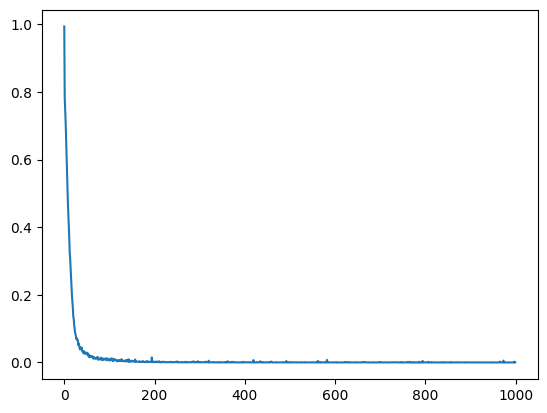

In [31]:
plt.plot(history)
plt.show()

Epoch 1/1000
	 - loss: 0.17452935874462128, score: 0.35708822701828596
Epoch 2/1000
	 - loss: 0.12348877638578415, score: 0.37604515801265426
Epoch 3/1000
	 - loss: 0.11034483462572098, score: 0.41638212580301937
Epoch 4/1000
	 - loss: 0.10279673337936401, score: 0.45295259995104836
Epoch 5/1000
	 - loss: 0.099041648209095, score: 0.481925328478846
Epoch 6/1000
	 - loss: 0.09564779698848724, score: 0.49185330017396167
Epoch 7/1000
	 - loss: 0.09614631533622742, score: 0.4906351619003267
Epoch 8/1000
	 - loss: 0.09507384896278381, score: 0.490451073011201
Epoch 9/1000
	 - loss: 0.09297890961170197, score: 0.5011224055964983
Epoch 10/1000
	 - loss: 0.09014187753200531, score: 0.5031165223602597
Epoch 11/1000
	 - loss: 0.08906103670597076, score: 0.5111274492143443
Epoch 12/1000
	 - loss: 0.09308291226625443, score: 0.5082661631571308
Epoch 13/1000
	 - loss: 0.08691900223493576, score: 0.5020461470822942
Epoch 14/1000
	 - loss: 0.08678556233644485, score: 0.5002235175603631
Epoch 15/1000


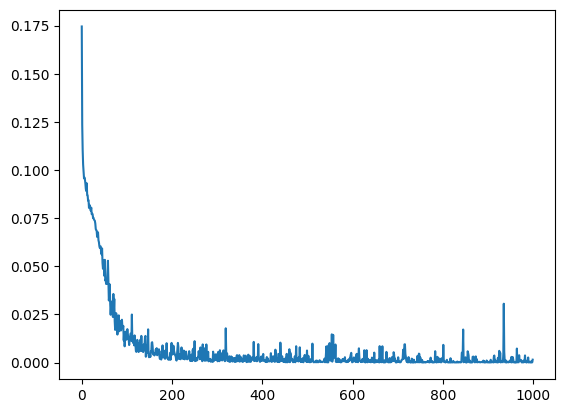

In [32]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)


n_input_dim = X_train.shape[1]

class SimpleFFN(nn.Module):
    def __init__(self):
        super(SimpleFFN, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.output  = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm_1 = nn.BatchNorm1d(1024)
        self.batchnorm_2 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm_2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x


BATCH_SIZE = 1024

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)

model = SimpleFFN()

loss_func = nn.BCELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 1000

model.train()
history = []
for epoch in range(epochs):
    
    model.train()
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_func(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
#     optimizer.zero_grad()
#     y_pred = model(X_train_tensor)
#     loss = loss_func(y_pred.squeeze(), y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
        print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
#     if epoch % 1 == 0:
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test_tensor)
#             score = ndcg_score([y_test_tensor.numpy()], [y_pred[:, 0]])
#             print(f"Epoch {epoch+1}/{epochs}\n\t - loss: {loss.item()}, score: {score}")
    
    history.append(loss.item())
        
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

print(ndcg_score([y_test], [y_pred[:, 0]]))

plt.plot(history)
plt.show()